# Kaggle Classification Challenge

**From: https://www.kaggle.com/c/dsi-east-1-project-3-classification **


In this challenge, you will use the well known Ames housing data to create a classification model that predicts whether the sale of a house in Ames, IA was abnormal or not. You should feel free to use any and all features that are present in this dataset..

**Goal**

It is your job to predict whether a sale was made in an abnormal fashion or not.. For each Id in the test set, you must:.

1. Classify the `Sale Condition` value as abnormal or not.
2. Transform this feature so that 1=abnormal and 0=not abnormal.



**This codebook was written by Chris Mantell (me) and was used as the first-place submission for the Kaggle Competition listed above.  I was also experimenting with pipelines and had not yet learned how to use FunctionTransformer correctly when this code was written.  A better example of pipelines will be pushed to github in the future.**

In [4]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression

% matplotlib inline
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Need this class for dummy pipelines later

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [6]:
# read in the housing data set
train = pd.read_csv('./train.csv')

In [7]:
#Explore column names
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

# EDA

**Qualitative Exploratory Analysis**

In [8]:
#Look at numbers of rows and columns
print(train.shape)

(2051, 82)


In [9]:
#Need to make dummies for object values (Street, Central Air, etc.), and MS SubClass
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 82 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

**Train Null values - Category(data_type): Lot Frontage(float64), Alley(object), Bsmt Qual(object), Bsmt Cond(object), Bsmt Exposure(object), Mas Vnr Type(object), Mas Vnr Area(float64), BsmtFin Type 1(object), BsmtFin Type 2(object), Garage Yr Blt(float64), Fireplace Qu((object), Garage Type(object), Garage Finish(object), Garage Qual(object), Garage Cond(object), Pool QC(object), Fence(object), Misc Feature(object), BsmtFin SF 1(float64), BsmtFin SF 2(float64), Bsmt Unf SF(float64),Total Bsmt SF(float64), Bsmt Full Bath(float64), Bsmt Half Bath(float64), Garage Cars(float64), Garage Area(float64)**

In [10]:
#No negative values across train dataset
train.describe().iloc[:, 6:27]
#Check year Built and Garage Yr Blt

,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,...,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt
count,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,...,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000
mean,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,...,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796
std,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,...,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094
min,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000
25%,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,...,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000
50%,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,...,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000
75%,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,...,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000
max,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,...,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000


In [15]:
# Use to see all columns
pd.set_option('display.max_columns', 90)

In [16]:
# Only one 2010.  Assuming not a mistake
train.loc[(train['Year Built'] > 2008)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
19,69,528458070,60,FV,72,8640,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,Mn,GLQ,24,Unf,0,732,756,GasA,Ex,Y,SBrkr,764,783,0,1547,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2009,Unf,2,614,TA,TA,Y,169,45,0,0,0,0,NaN,NaN,NaN,0,6,2010,Con,Normal,215200
70,242,905453080,20,RL,44,17485,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,7,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,96,Gd,TA,PConc,Gd,TA,Gd,GLQ,1346,Unf,0,162,1508,GasA,Ex,Y,SBrkr,1508,0,0,1508,1,0,1,0,1,1,Gd,5,Typ,2,TA,Attchd,2009,RFn,2,572,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,1,2010,Con,Partial,308030
144,105,533238045,20,FV,57,12853,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2010,2010,Gable,CompShg,CemntBd,CmentBd,None,0,Gd,TA,PConc,Ex,Po,No,GLQ,1032,Unf,0,610,1642,GasA,Ex,Y,SBrkr,1418,0,0,1418,1,0,1,1,1,1,Gd,6,Typ,1,Gd,Attchd,2010,RFn,3,852,TA,TA,Y,160,192,0,224,0,0,NaN,NaN,NaN,0,4,2010,New,Partial,267916
172,68,528456160,20,FV,92,9215,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1218,1218,GasA,Ex,Y,SBrkr,1218,0,0,1218,0,0,2,0,2,1,Gd,4,Typ,0,NaN,Attchd,2009,RFn,2,676,TA,TA,Y,0,136,0,0,0,0,NaN,NaN,NaN,0,4,2010,New,Partial,204500
369,319,916386090,60,RL,92,12003,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,2Story,8,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,BrkFace,84,Gd,TA,PConc,Ex,TA,No,Unf,0,Unf,0,774,774,GasA,Ex,Y,SBrkr,774,1194,0,1968,0,0,2,1,4,1,Ex,8,Typ,1,Gd,BuiltIn,2009,Fin,3,680,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,New,Partial,269500
398,37,528108120,60,RL,102,12858,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2009,2010,Gable,CompShg,VinylSd,VinylSd,Stone,162,Ex,TA,PConc,Ex,TA,No,Unf,0,Unf,0,1590,1590,GasA,Ex,Y,SBrkr,1627,707,0,2334,0,0,2,1,3,1,Ex,10,Typ,1,Gd,Attchd,2009,Fin,3,751,TA,TA,Y,144,133,0,0,0,0,NaN,NaN,NaN,0,1,2010,New,Partial,376162
625,517,528456240,20,FV,75,7862,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,TA,No,GLQ,27,Unf,0,1191,1218,GasA,Ex,Y,SBrkr,1218,0,0,1218,0,0,2,0,2,1,Gd,4,Typ,0,NaN,Attchd,2009,Fin,2,676,TA,TA,Y,0,102,0,0,0,0,NaN,NaN,NaN,0,9,2009,New,Partial,208300
637,522,528458160,20,FV,85,9187,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,9,5,2009,2009,Gable,CompShg,CemntBd,CmentBd,Stone,162,Ex,TA,PConc,Ex,TA,Mn,GLQ,1121,Unf,0,645,1766,GasA,Ex,Y,SBrkr,1766,0,0,1766,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2009,Fin,3,478,TA,TA,Y,195,130,0,0,0,0,NaN,NaN,NaN,0,10,2009,New,Partial,370878
963,568,533210020,160,FV,30,3000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,6,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,Stone,76,Gd,TA,PConc,Gd,TA,Av,GLQ,294,Unf,0,318,612,GasA,Ex,Y,SBrkr,612,612,0,1224,0,0,2,1,2,1,Gd,4,Typ,0,NaN,Detchd,2009,RFn,2,528,TA,TA,Y,0,234,0,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,173733
1060,819,906340100,20,RL,84,10933,P

In [17]:
# Fix incorrect value at index 1699 - Assumed typo.  Should be 2007
train.loc[(train['Garage Yr Blt'] == 2207)]
train.set_value(1699, 'Garage Yr Blt', 2007)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289,Gd,TA,CBlock,TA,TA,No,GLQ,533,Unf,0,192,725,GasA,Ex,Y,SBrkr,725,754,0,1479,0,0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976,RFn,2,475,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132,Gd,TA,PConc,Gd,TA,No,GLQ,637,Unf,0,276,913,GasA,Ex,Y,SBrkr,913,1209,0,2122,1,0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997,RFn,2,559,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0,TA,Gd,CBlock,TA,TA,No,GLQ,731,Unf,0,326,1057,GasA,TA,Y,SBrkr,1057,0,0,1057,1,0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953,Unf,1,246,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000
3,318,916386060,60,RL,73,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,SBrkr,744,700,0,1444,0,0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,174000
4,255,906425045,50,RL,82,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0,TA,TA,PConc,Fa,Gd,No,Unf,0,Unf,0,676,676,GasA,TA,Y,SBrkr,831,614,0,1445,0,0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957,Unf,2,484,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,138500
5,138,535126040,20,RL,137,16492,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,PosA,Norm,1Fam,1Story,6,6,1966,2002,Gable,CompShg,BrkFace,Plywood,None,0,Gd,TA,CBlock,TA,TA,No,ALQ,247,Rec,713,557,1517,GasA,Ex,Y,SBrkr,1888,0,0,1888,0,0,2,1,2,1,Gd,6,Mod,1,Gd,Attchd,1966,Fin,2,578,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
6,2827,908186070,180,RM,35,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SFoyer,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,82,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,Gd,Y,SBrkr,1072,0,0,1072,1,0,2,0,2,1,TA,5,Typ,0,NaN,Basment,2005,Fin,2,525,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1959,1959,Hip,CompShg,Plywood,Plywood,BrkFace,180,TA,TA,CBlock,TA,TA,No,Rec,1000,Unf,0,188,1188,GasA,Fa,Y,SBrkr,1188,0,0,1188,1,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1959,RFn,2,531,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,5,1952,1952,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,CBlock,TA,TA,No,Rec,292,Unf,0,632,924,GasA,TA,Y,SBrkr,924,0,0,924,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1952,Unf,1,420,TA,TA,Y,0,324,0,0,0,0,NaN,MnPrv,Shed,400,6,2007,WD,Normal,112500
9,1956,535426130,60,RL,70,11606,Pave,NaN,IR1,HLS,AllPub,Insid

In [18]:
# Check to see if bad value was removed
train.loc[(train['Garage Yr Blt'] == 2207)]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice


In [19]:
#Need to get dummies - Nan means no alley
print(train['Alley'].unique())

[nan 'Pave' 'Grvl']


In [20]:
# Make binary values for remodel/addition or not based on if value from 'YearBuilt' = 'YearRemodelAdd'
train[['Year Built','Year Remod/Add']].head()


,Year Built,Year Remod/Add
0,1976,2005
1,1996,1997
2,1953,2007
3,2006,2007
4,1900,1993


In [21]:
train['Remodel'] = np.where(train['Year Built'] == train['Year Remod/Add'], 0, 1)

In [22]:
# NaN means no pool
print(train['Pool QC'].unique())

[nan 'Fa' 'Gd' 'Ex' 'TA']


In [23]:
# NaN means no fence
print(train['Fence'].unique())

[nan 'MnPrv' 'GdPrv' 'GdWo' 'MnWw']


In [24]:
# NaN means no miscellaneous feature
print(train['Misc Feature'].unique())

[nan 'Shed' 'TenC' 'Gar2' 'Othr' 'Elev']


In [25]:
#Needs imputer.  Assuming you can't have 0 feet of street connected to your property
train['Lot Frontage'].head()

0   NaN
1    43
2    68
3    73
4    82
Name: Lot Frontage, dtype: float64

In [26]:
# Make column if condition 1 == condition 2 
train.loc[:, ('Condition 1', 'Condition 2')]
train['Two_Conditions'] = np.where(train['Condition 1'] == train['Condition 2'], 0, 1)

In [27]:
# Make binary column for multiple exterior types if exterior 1st = exterior 2nd
train.loc[:, ('Exterior 1st', 'Exterior 2nd')]
train['Two Exteriors'] = np.where(train['Exterior 1st'] == train['Exterior 2nd'], 0, 1)

In [28]:
# Nan means no basement - Maybe need dummies
train['Bsmt Qual'].unique()

array(['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'], dtype=object)

In [29]:
# Nan means no basement - Maybe need dummies
train['Bsmt Cond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'], dtype=object)

In [30]:
# Nan means no basement - Maybe need dummies
train['Bsmt Exposure'].unique()

array(['No', 'Gd', 'Av', nan, 'Mn'], dtype=object)

In [31]:
# Change NaN to 0
train["BsmtFin SF 1"].isnull().sum()

1

In [32]:
# Change NaN to 0
train["BsmtFin SF 2"].isnull().sum()

1

In [33]:
# Change NaN to 0
train['Bsmt Unf SF'].isnull().sum()

1

In [34]:
# Change NaN to 0
train['Total Bsmt SF'].isnull().sum()

1

In [35]:
# Nan means no basement - Maybe need dummies
train['Bsmt Full Bath'].unique()

array([  0.,   1.,   2.,  nan,   3.])

In [36]:
# Nan means no basement - Maybe need dummies
train['Bsmt Half Bath'].unique()

array([  0.,   1.,  nan,   2.])

In [37]:
# Nan means no basement - Maybe need dummies
train['BsmtFin Type 1'].unique()

array(['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'], dtype=object)

In [38]:
# Nan means no basement or means no second type of finished basement? - Maybe need dummies 
train['BsmtFin Type 2'].unique()

array(['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'], dtype=object)

In [39]:
#Change Nan to None
train['Mas Vnr Type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [40]:
#Change NaN to 0 - No Masonry 
train['Mas Vnr Area'].head()

0    289
1    132
2      0
3      0
4      0
Name: Mas Vnr Area, dtype: float64

In [41]:
# NaN means no garage?  Make NaN 0?
train['Garage Yr Blt'].isnull().sum()

114

In [42]:
# Describe data of Garage Year Built
train['Garage Yr Blt'].describe()

count    1937.000000
mean     1978.604543
std        24.914493
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: Garage Yr Blt, dtype: float64

In [43]:
# Binarize Garage Yr. Blt to 0 for NaN and 1 for any year or drop column?
train.loc[(train['Garage Yr Blt'].isnull())]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Remodel,Two_Conditions,Two Exteriors
28,2243,911103060,190,C (all),75,8250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,2fmCon,2Story,5,6,1895,2006,Gable,CompShg,VinylSd,VinylSd,None,0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,957,957,GasA,Fa,N,SBrkr,1034,957,0,1991,0,0,2,0,4,2,TA,9,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,133,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,119600,1,1,0
53,330,923226250,160,RM,21,1476,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0,TA,TA,CBlock,TA,TA,No,GLQ,176,Unf,0,370,546,GasA,Ex,Y,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,200,26,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal,76000,0,0,1
65,2278,923202134,20,RL,70,8402,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Feedr,Norm,1Fam,1Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,ALQ,206,Unf,0,914,1120,GasA,Ex,Y,SBrkr,1120,0,0,1120,0,0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,30,0,0,0,0,NaN,NaN,NaN,0,12,2007,New,Partial,147000,0,1,0
79,2235,910201050,50,RM,50,7288,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1925,2003,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,Gd,BrkTil,TA,Po,No,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,665,0,1601,0,0,2,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,176,0,0,NaN,NaN,NaN,0,9,2007,WD,Normal,129850,1,1,0
101,2084,905476170,30,RL,58,9098,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,7,1920,2002,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,TA,Mn,ALQ,348,Unf,0,180,528,GasA,Ex,Y,SBrkr,605,0,0,605,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,144,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,86000,1,0,0
103,728,902477130,30,C (all),72,9392,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,3,1900,1950,Mansard,CompShg,AsbShng,AsbShng,None,0,TA,Fa,CBlock,Fa,TA,No,Unf,0,Unf,0,245,245,GasA,TA,N,SBrkr,797,0,0,797,0,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,36,94,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Abnorml,44000,1,0,0
114,781,905228050,20,RL,NaN,9000,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Norm,Norm,1Fam,1Story,2,2,1947,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,SBrkr,660,0,0,660,0,0,1,0,2,1,Fa,5,Min2,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,100,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,63900,1,0,0
120,1492,908127120,30,RL,63,13907,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1940,1969,Gable,CompShg,WdShing,Wd Shng,None,0,TA,TA,CBlock,TA,TA,No,BLQ,290,Unf,0,706,996,GasA,Ex,Y,SBrkr,996,0,0,996,1,0,1,0,3,1,TA,6,Typ,1,Gd,NaN,NaN,NaN,0,0,NaN,NaN,Y,144,0,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal,108000,1,0,1
134,1514,909100170,30,RL,67,5604,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1925,1950,Gable,CompShg,Stucco,Stucco,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,Unf,0,396,864,GasA,TA,N,FuseA,864,0,0,864,1,0,1,0,2,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,96,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal,98000,1,0,0
136,216,905101100,

In [44]:
#NaN means no garage 
train['Garage Type'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'Basment', nan, '2Types', 'CarPort'], dtype=object)

In [45]:
#NaN means no garage 
train['Garage Cond'].unique()

array(['TA', 'Fa', nan, 'Po', 'Gd', 'Ex'], dtype=object)

In [46]:
#NaN means no garage 
train['Garage Qual'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'], dtype=object)

In [47]:
#NaN means no garage
train['Garage Cars'].unique()

array([  2.,   1.,   3.,   0.,   4.,   5.,  nan])

In [48]:
#NaN means no garage 
train['Garage Finish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

In [49]:
# Change NaN to 0
train['Garage Area'].isnull().sum()

1

In [51]:
# NaN means no fireplace 
train['Fireplace Qu'].unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [52]:
#Make list of columns where 0 needs to replace NaN
columns_change_NaN_to_0 = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Mas Vnr Area', 'Garage Area']

In [53]:
#List of columns without nulls that need dummies
dummy_columns_without_NaNs = ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope',
                              'Neighborhood', 'Condition 1', 'Condition 2', 'Mas Vnr Type', 
                             'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
                             'Exterior 1st', 'Exterior 2nd', 'Exter Qual',  'Exter Cond', 'Foundation',
                             'Heating', 'Heating QC', 'Central Air', 'Electrical',
                             'Kitchen Qual', 'Functional', 'Paved Drive', 'Sale Type']

In [54]:
# List of columns with nulls that need dummies
dummy_columns_with_NaNs = ['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'Fireplace Qu',  
                           'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Full Bath',
                           'Bsmt Half Bath', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Garage Cars']

**Preprocessing**

In [63]:
# Import preprocessing libraries
from sklearn.preprocessing import Imputer, Binarizer, PolynomialFeatures, OneHotEncoder, FunctionTransformer

In [57]:
#Drop PID column - no predictive value
train.drop(['PID'], axis=1, inplace=True)

In [58]:
#Assume NaN is the smae as None for Masonary
train['Mas Vnr Type'].fillna('None', inplace=True)

In [61]:
#Fill in NaNs as 0 for float columns
train[columns_change_NaN_to_0] = train[columns_change_NaN_to_0].apply(lambda x: x.fillna(0))

In [62]:
# Check to see if it worked
train[columns_change_NaN_to_0].isnull().sum()

BsmtFin SF 1     0
BsmtFin SF 2     0
Bsmt Unf SF      0
Total Bsmt SF    0
Mas Vnr Area     0
Garage Area      0
dtype: int64

In [64]:
#Will drop Garage Year Built because I'm not sure how to transform the feature
train.drop(['Garage Yr Blt'], axis=1, inplace=True)

In [65]:
# Not many points for other data points - make binary classification
train['Sale Condition'].value_counts()

Normal     1696
Partial     164
Abnorml     132
Family       29
Alloca       19
AdjLand      11
Name: Sale Condition, dtype: int64

In [66]:
# Map the Sale Condition for abnormal = 1, and all others = 0
train['Sale Condition'] = train['Sale Condition'].map(lambda x: 1 if x == 'Abnorml' else 0)

In [67]:
# Create target variable for classification.  Drop column from train set because it won't be in testing set
target = train['Sale Condition']
train.drop(['SalePrice'], axis=1, inplace=True)

In [68]:
#Preprocess Garage Cars for Categorical Encoder
train['Garage Cars'].fillna(-1, inplace=True)

In [69]:
#Set column as integers for Categorical Encoder
train['Garage Cars'] = train['Garage Cars'].astype(int)

In [70]:
#Define function to process all columns needed for Categorical Encoder
def one_hot_encoder_processor(DataFrame, columns):
    '''Function removes NaNs and sets column values as integers'''
    for col in columns:
        DataFrame[col].fillna(-1, inplace=True)
        DataFrame[col] = DataFrame[col].astype(int)
    

    

In [71]:
#Preprocess other columns for Categorical Encoder with new function
one_hot_encoder_processor(train, ['Bsmt Full Bath', 'Bsmt Half Bath'])

In [72]:
# Make lists of column names for preprocessing
string_dummy_with_NaNs = [col for col in dummy_columns_with_NaNs if col != ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']]
int_dummy_with_NaNs = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

In [73]:
#Preprocess string columns for categorical encoder
def string_categorical_encoder_processor(DataFrame, columns):
    '''Function takes columns values and replaces NaN with string N/A'''
    for col in columns:
        DataFrame[col].fillna('N/A', inplace=True)

In [74]:
# Use new function for string categorical encoder preprocessing
string_categorical_encoder_processor(train, string_dummy_with_NaNs)

In [75]:
#Set training index to Id.  Also removes Id as a feature - no predictive value
train.set_index('Id', inplace=True)

In [76]:
#Test_train_split and stratify results for classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.33, random_state=50, stratify=target)

# Feature Extraction and Modeling

In [77]:
#Find baseline model classification
train['Sale Condition'].value_counts()

0    1919
1     132
Name: Sale Condition, dtype: int64

In [78]:
#Baseline is most accuracy when you guess the most common class
baseline = 1919/(1919+132)
baseline

0.9356411506582155

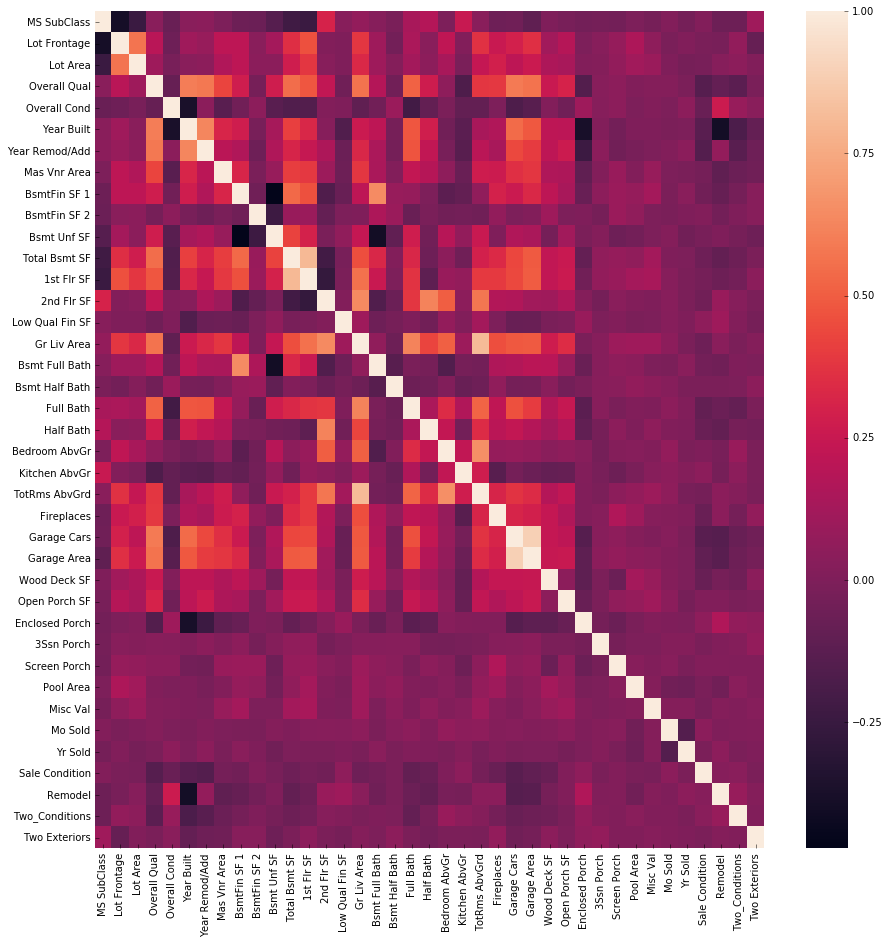

In [79]:
# Plot correlation heatmap for data visualization for possible feature selection.  Too many features even for this visualization.
plt.figure(figsize=(15,15))
train_corr = train.corr()
sns.heatmap(train_corr)

**Make pipelines**

In [80]:
#Create class to extract column name for pipelines
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[[self.column]].values 
    

In [81]:
#Create class to extract categorical columns for pipelines
class CategoricalExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.values = None
        
    def _create_values(self, indices):
        return {ind: i+1 for i, ind in enumerate(indices)}
    
    def _apply_values(self, row_val):
        return self.values.get(row_val, 0)
        
    def fit(self, X, y=None):
        self.values = self._create_values(X[self.column].value_counts().index)
        return self 
    
    def transform(self, X, y=None):
        col = X[self.column].apply(self._apply_values)
        return col.values.reshape(-1, 1)

In [82]:
#Function needed for FunctionTransformer
def get_integer_columns(DataFrame):
    return DataFrame[int_dummy_with_NaNs]


In [83]:
#Integer related dummy variables
X_train[int_dummy_with_NaNs].head()

,Bsmt Full Bath,Bsmt Half Bath,Garage Cars
Id,,,
2918,0,0,1
2808,1,0,2
759,0,0,1
1345,0,0,2
2445,1,0,3


In [84]:
#FunctionTransformer was throwing errors.  Need to make individual pipelines due to time constraints.
#init dummy variables
Bsmt_Full_Bath_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bsmt Full Bath'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore')
                                         
)

In [85]:
#FunctionTransformer was throwing errors.  Need to make individual pipelines due to time constraints.
#init dummy variables
Bsmt_Half_Bath_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bsmt Half Bath'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore')
                                         
)

In [86]:
#FunctionTransformer was throwing errors.  Need to make individual pipelines due to time constraints.
#init dummy variables
Garage_Cars_encoder_pipeline = make_pipeline(
    FeatureExtractor('Garage Cars'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore')
                                         
)

In [87]:
#FunctionTransformer was throwing errors.  Need to make individual pipelines due to time constraints.
#string_dummy_with_NaNs
Alley_encoder_pipeline = make_pipeline(
    FeatureExtractor('Alley'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Pool_encoder_pipeline = make_pipeline(
    FeatureExtractor('Pool QC'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Fence_encoder_pipeline = make_pipeline(
    FeatureExtractor('Fence'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Misc_Feature_encoder_pipeline = make_pipeline(
    FeatureExtractor('Misc Feature'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Fireplace_encoder_pipeline = make_pipeline(
    FeatureExtractor('Fireplace Qu'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Bsmt_Qual_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bsmt Qual'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Bsmt_Cond_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bsmt Cond'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Bsmt_Exposure_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bsmt Exposure'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

BsmtFin_Type_1_encoder_pipeline = make_pipeline(
    FeatureExtractor('BsmtFin Type 1'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

BsmtFin_Type_2_encoder_pipeline = make_pipeline(
    FeatureExtractor('BsmtFin Type 2'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Garage_Type_encoder_pipeline = make_pipeline(
    FeatureExtractor('Garage Type'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Garage_Finish_encoder_pipeline = make_pipeline(
    FeatureExtractor('Garage Finish'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Garage_Qual_encoder_pipeline = make_pipeline(
    FeatureExtractor('Garage Qual'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Garage_Cond_encoder_pipeline = make_pipeline(
    FeatureExtractor('Garage Cond'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

In [88]:
#FunctionTransformer was throwing errors.  Need to make individual pipelines due to time constraints.
#dummy_columns_without_NaNs
MS_Zoning_encoder_pipeline = make_pipeline(
    FeatureExtractor('MS Zoning'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Street_encoder_pipeline = make_pipeline(
    FeatureExtractor('Street'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Lot_Shape_encoder_pipeline = make_pipeline(
    FeatureExtractor('Lot Shape'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Land_Contour_encoder_pipeline = make_pipeline(
    FeatureExtractor('Land Contour'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Utilities_encoder_pipeline = make_pipeline(
    FeatureExtractor('Utilities'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Lot_Config_encoder_pipeline = make_pipeline(
    FeatureExtractor('Lot Config'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Land_Slope_encoder_pipeline = make_pipeline(
    FeatureExtractor('Land Slope'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Neighborhood_encoder_pipeline = make_pipeline(
    FeatureExtractor('Neighborhood'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
Condition_1_encoder_pipeline = make_pipeline(
        FeatureExtractor('Condition 1'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
Condition_2_encoder_pipeline = make_pipeline(
        FeatureExtractor('Condition 2'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
Mas_Vnr_Type_encoder_pipeline = make_pipeline(
        FeatureExtractor('Mas Vnr Type'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
Bldg_Type_encoder_pipeline = make_pipeline(
    FeatureExtractor('Bldg Type'),
    CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
House_Style_encoder_pipeline = make_pipeline(
        FeatureExtractor('House Style'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))
    
Roof_Style_encoder_pipeline = make_pipeline(
        FeatureExtractor('Roof Style'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Roof_Matl_encoder_pipeline = make_pipeline(
        FeatureExtractor('Roof Matl'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Exterior_1st_encoder_pipeline = make_pipeline(
        FeatureExtractor('Exterior 1st'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Exterior_2nd_encoder_pipeline = make_pipeline(
        FeatureExtractor('Exterior 2nd'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Exter_Qual_encoder_pipeline = make_pipeline(
        FeatureExtractor('Exter Qual'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Exter_Cond_encoder_pipeline = make_pipeline(
        FeatureExtractor('Exter Cond'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Foundation_encoder_pipeline = make_pipeline(
        FeatureExtractor('Foundation'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Heating_encoder_pipeline = make_pipeline(
        FeatureExtractor('Heating'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Heating_QC_encoder_pipeline = make_pipeline(
        FeatureExtractor('Heating QC'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Central_Air_encoder_pipeline = make_pipeline(
        FeatureExtractor('Central Air'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Electrical_encoder_pipeline = make_pipeline(
        FeatureExtractor('Electrical'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Kitchen_Qual_encoder_pipeline = make_pipeline(
        FeatureExtractor('Kitchen Qual'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Functional_encoder_pipeline = make_pipeline(
        FeatureExtractor('Functional'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Paved_Drive_encoder_pipeline = make_pipeline(
        FeatureExtractor('Paved Drive'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

Sale_Type_encoder_pipeline = make_pipeline(
        FeatureExtractor('Sale Type'),
        CategoricalEncoder(encoding='onehot-dense', handle_unknown='ignore'))

In [89]:
#Imputer pipeline
lot_frontage_imputer_pipeline = make_pipeline(
    FeatureExtractor('Lot Frontage'),
    Imputer(strategy='median')
)

In [90]:
#Import Scaler for after transforming features
from sklearn.preprocessing import RobustScaler

In [91]:
#Make feature union of all dummy variables and imputation
feature_transformers = make_union(
    Bsmt_Full_Bath_encoder_pipeline,
    Bsmt_Half_Bath_encoder_pipeline,
    Garage_Cars_encoder_pipeline,
    MS_Zoning_encoder_pipeline,
    Street_encoder_pipeline,
    Lot_Shape_encoder_pipeline,
    Land_Contour_encoder_pipeline,
    Utilities_encoder_pipeline,
    Lot_Config_encoder_pipeline,
    Land_Slope_encoder_pipeline,
    Neighborhood_encoder_pipeline,
    Condition_1_encoder_pipeline,
    Condition_2_encoder_pipeline,
    Mas_Vnr_Type_encoder_pipeline,
    Bldg_Type_encoder_pipeline,
    House_Style_encoder_pipeline,
    Roof_Matl_encoder_pipeline,
    Roof_Style_encoder_pipeline,
    Exterior_1st_encoder_pipeline,
    Exterior_2nd_encoder_pipeline,
    Exter_Cond_encoder_pipeline,
    Exter_Qual_encoder_pipeline,
    Foundation_encoder_pipeline,
    Heating_QC_encoder_pipeline,
    Heating_encoder_pipeline,
    Central_Air_encoder_pipeline,
    Electrical_encoder_pipeline,
    Kitchen_Qual_encoder_pipeline,
    Functional_encoder_pipeline,
    Paved_Drive_encoder_pipeline,
    Sale_Type_encoder_pipeline,
    lot_frontage_imputer_pipeline 
)

In [92]:
#Modeling pipeline with RandomForestClassifier
modeling_pipe = make_pipeline(
    feature_transformers,
    RobustScaler(),
    RandomForestClassifier(n_estimators=35, max_features=20)
)

In [93]:
#Fit pipeline to training data
modeling_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor(column='Bsmt Full Bath')), ('categoricalencoder', CategoricalEncoder(categories='auto', dtype=<class 'numpy.float64'>,
          encoding='on...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [94]:
#Scoring pipeline to testing data.  About the same as baseline
modeling_pipe.score(X_test, y_test)

0.93353028064992616

# Submission

In [95]:
#Check train shape
X_train.shape

(1374, 81)

In [96]:
#Check test shape
test = pd.read_csv('./test.csv')
test.shape

(879, 80)

In [97]:
#Make same columns in test as train
test.loc[:, ('Condition 1', 'Condition 2')]
test['Two_Conditions'] = np.where(test['Condition 1'] == test['Condition 2'], 0, 1)

In [98]:
#Make same columns in test as train
test.loc[:, ('Exterior 1st', 'Exterior 2nd')]
test['Two Exteriors'] = np.where(test['Exterior 1st'] == test['Exterior 2nd'], 0, 1)

In [99]:
#Drop same columns in test as train
test.drop(['PID'], axis=1, inplace=True)

In [100]:
#Fill in same NaN in test as in train
test['Mas Vnr Type'].fillna('None', inplace=True)

In [101]:
#Make same columns in test as train
test['Remodel'] = np.where(test['Year Built'] == test['Year Remod/Add'], 0, 1)

In [102]:
#Check final shape.  Same as training and testing data!
test.shape

(879, 82)

In [103]:
#Make predictions
predictions = modeling_pipe.predict(test)

In [104]:
# Make sumbission dataframe
classification_submission = pd.DataFrame(data=test['Id'])

In [105]:
# Append predictions tosumbission dataframe
classification_submission['Sale Condition'] = predictions

In [106]:
#Set index for submission
classification_submission.set_index('Id', inplace=True)

In [107]:
#Check submission
classification_submission.head()

,Sale Condition
Id,
2658,0
2718,0
2414,0
1989,0
625,0


In [108]:
#Export to csv
classification_submission.to_csv('./classification_submission.csv')